## 8.1 季節自己回帰和分移動平均(SARIMA)モデル

季節自己回帰和文移動平均SARIMA(p,d,q)$(P,D,Q)_m$は、ARIMA(p,d,q)モデルに季節パラメータを追加することで拡張したものです。


このモデルには、新しいパラメータが4つあります。→（P,D,Q,m）

最初の3つのパラメータの意味はARIMA(p,d,q)モデルと同じもので、その季節バージョン。

Pは季節的なAR(P)プロセスの次数、Dは季節的な和文次数、Qは季節的なMA(Q)プロセスの次数、mは頻度を表す。








時系列における頻度は、周期あたりの観測の回数として定義されます。

周期の長さはデータセットによって異なり、年、四半期、月、または週ごとに記録するデータの場合、周期の長さは1年とみなされます。

年次的に記録されるデータ(観測は1年に1回)→m=1

四半期ごとに記録されるデータ(観測は1年に４回)→m=4

月次的に記録されるデータ(観測は1年に12回)→m=12

週次的に記録されるデータ(観測は1年に52回)→m=52



データが日次またはそれよりも短い間隔で収集される場合は以下の通り。

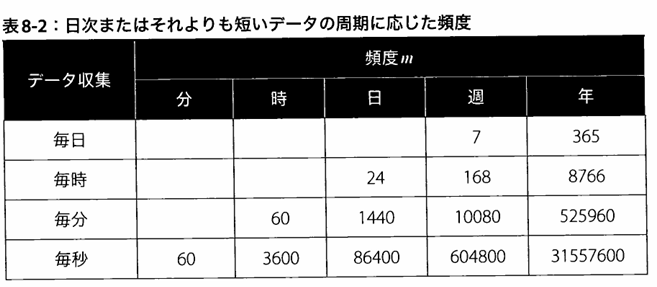



# SARIMAモデルの形式

SARIMAモデルは以下のように表されます。

$
Φ(L^s
 )ϕ(L)(1−L)^d
 (1−L^s
 )^D
 y_t
​
 =C+Θ(L^s
 )θ(L)ε_t
​$


ただし、以下の通りとする。

$
ϕ(x):=1−\sum_{i=1}^{p}\phi_ix^i
$

$
Φ(x)=1-
\sum_{i}^{p}
​
 Φ_i
​
 x^i
$

$
θ(x):=1+
\sum_{i=1}^{q}
 θ_i
​
 x^i
$

$
Θ(x)=1+
\sum_{i}^{Q}
​
 Θ_i
​
 x_i
$

ex.  m=12の例について考える。

P=2の場合

「季節ラグ（12ヶ月ごと） の2つの過去の値」を使って、現在の値を説明するという意味なので、$y_{t-12}$と$y_{t-24}$の値を組み込むことになります。

D=1の場合

季節差分によって時系列が定常になることを意味します。この場合の季節差分は、
$y'_t
 =y_t
​
 −y_{t−12}
​
$
で表され、これにより、毎年の同じ月の変化をとることができます。

Q=2の場合

Q = 2 は、「季節ラグ（12ヶ月ごと） の2つの誤差項」を使うという意味なので、
$\epsilon_{t-12}$と$\epsilon_{t-24}$の値を組み込むことになります。





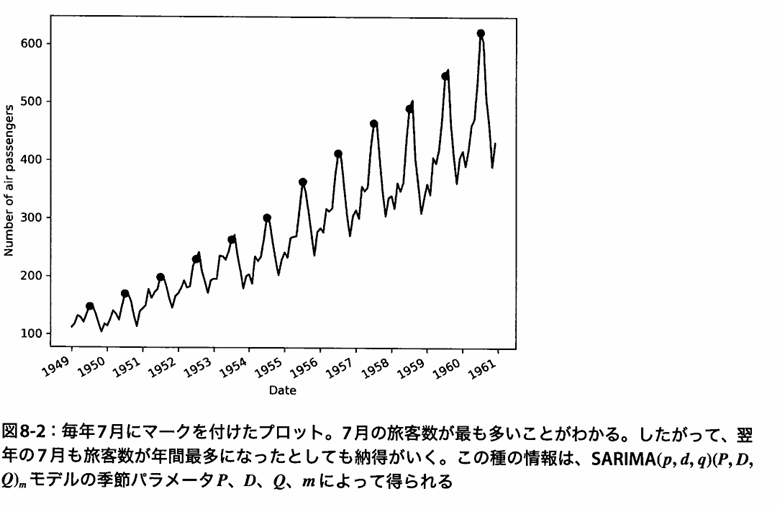

月間航空旅客数のデータを見ると、このデータは月次のデータなのでm=12であることがわかります。また、点で示されているように、数が最も多いのは7月なので、1961年の7月の数を予測する場合、1961年のピーク時であることが予想でき、前年の7月の情報が役立つ可能性があります。P,D,Q,mを使って1つ前の季節周期から情報を取り出せば、時系列予測に使うことが出来ます。

## 8.2  時系列で季節パターンを特定する

季節的なパターンが現れるデータでは、SARIMAモデルの適用が合理的。よって、時系列の季節性を見極める方法を突き止めることが重要です。

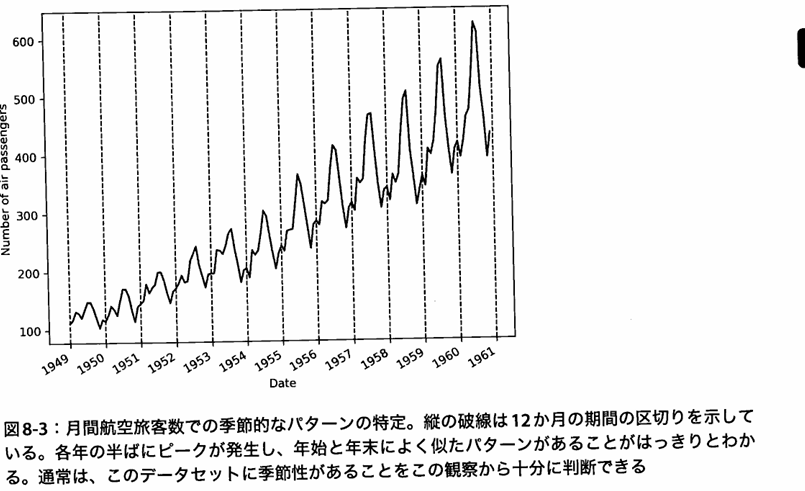

毎月の総旅客数を見ると、6,7,8月は増加し、11,12,1月は減少するというパターンが繰り返されていることが分かります。

時系列の季節的なパターンを見抜くもう一つの方法は時系列分解を分解をつかうことで、時系列分解は、時系列を3つの主成分(トレンド、季節性、残差)に分解する統計学的タスクです。

時系列分解を使って時系列の季節成分を明確に特定し、可視化してみましょう。


In [ ]:
from statsmodels.tsa.seasonal import STL
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df=pd.read_csv('air-passengers.csv')

decomposition=STL(df['Passengers'],period=12).fit()

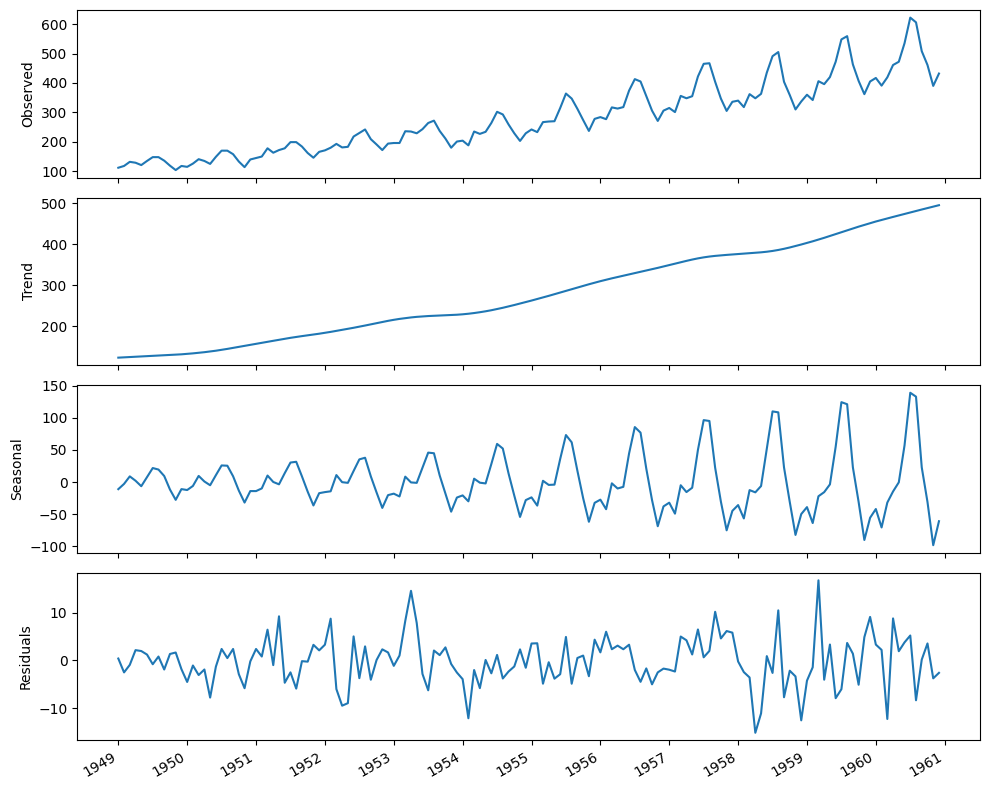

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

トレンド成分、季節成分、残差成分のプロットのy軸が観測データのものと少し異なるが、これはそれぞれのプロットがその成分に起因する変化の大きさを表しているためです。つまり、3つの成分を足し合わせると観測データになります。季節成分が負の値や正の値になったりするのは観測データの山と谷を作っているからです。

## 8.3  月ごとの航空旅客数を予測する

前章でARIMAモデルの一般的なモデル手続きについて触れたが、SARIMAモデルの新しいパラメータP,D,Q,mを考慮に入れるため、これを再度調整する必要があります。

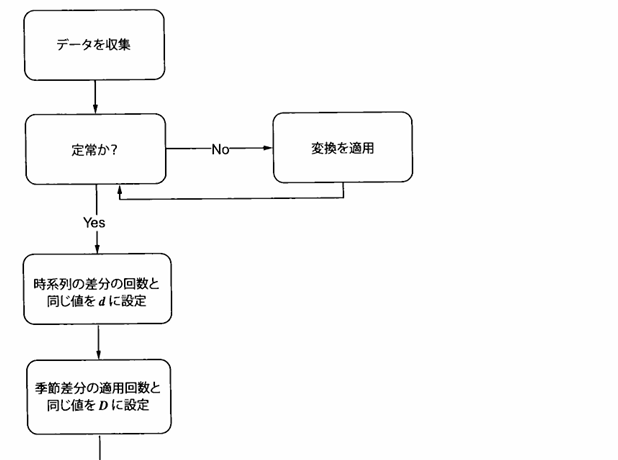
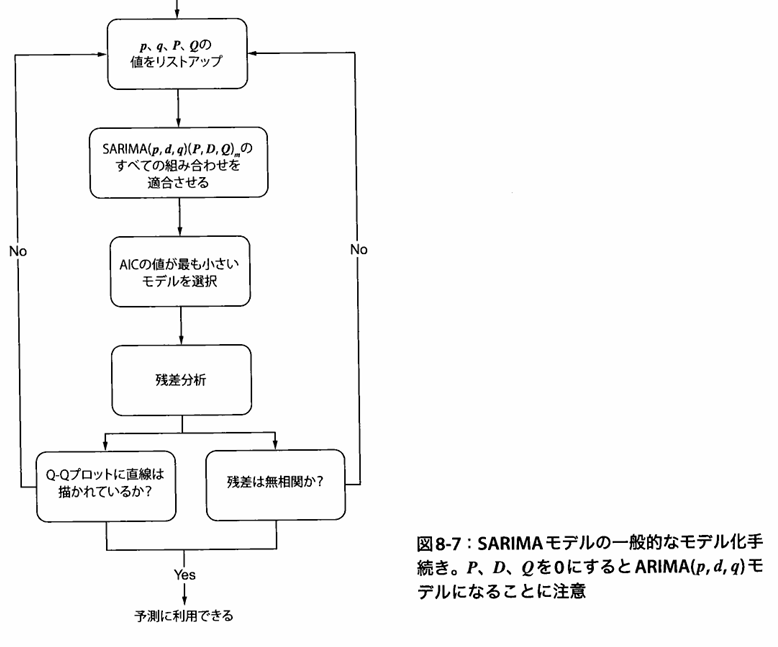

ベースラインモデルは単純な季節予測です。ここでは、ARIMA$(p,d,q)$モデルとSARIMA$(p,d,q)(P,D,Q)_m$モデルを使って。季節成分を追加すると予測性能が向上するかを検証します。

### 8.3.1 ARIMA(p,d,q)モデルで予測する。

まず、ARIMA(p,d,q)モデルを使ってデータセットをモデル化します。このようにすると、性能をSARIMA(p,d,q)(P,D,Q)$_m$モデルと比較できるようになります。

最初にADF検定を使って定常性をテストします。


In [ ]:
from statsmodels.tsa.stattools import adfuller

ad_fuller_result=adfuller(df['Passengers'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641


ADF統計量は0.82、p値は0.99なので、帰無仮説を棄却できず、この時系列は定常ではありません。時系列の差分をとり、定常性を再びテストします。

In [ ]:
df_diff=np.diff(df['Passengers'],n=1) #1次差分

ad_fuller_result=adfuller(df_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


ADF Statistic: -2.8292668241700047
p-value: 0.05421329028382478


ADF統計量は-2.83、p値は0.054なので、また帰無仮説を棄却することはできませんでした。もう一度差分をとり、定常性をテストしましょう。

In [ ]:
df_diff2=np.diff(df_diff,n=1)

ad_fuller_result=adfuller(df_diff2)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -16.384231542468513
p-value: 2.7328918500142026e-29


ADF統計量は-16.38、p値は2.73×10^(-29)なので、帰無仮説を棄却でき、時系列が定常とみなすことが出来ます。差分を2回とったのでd=2となります。

次に、パラメータp,qが取り得る値の範囲を定義して、一意なARIMA(p,d,q)モデルをすべて適合させることができます。具体的には０～１２の範囲を選択して、ARIMAモデルが時間ステップを12個さかのぼれるようにします。

In [ ]:
from itertools import product

ps=range(0,13,1) #季節情報を組み込むために範囲を0～12に設定
qs=range(0,13,1)
Ps=[0] #ARIMA(p,d,q)モデルを使っているのでPとQの値を0に設定
Qs=[0]

d=2
D=0 #ARIMA(p,d,q)モデルを使っているのでPとQの値を0に設定
s=12 #statsmodelsライブラリのパラメータsはmに相当し、頻度を表す

#(p,d,q)(0,0,0)の組み合わせとして考えられるものを生成
ARIMA_order_list=list(product(ps,qs,Ps,Qs))

P,D,Qを0に設定するのはSARIMA$(p,d,q)(0,0,0)_m$モデルはARIMA$(p,d,q)$モデルと同等だからです。

次にoptimize_SARIMA関数を定義します。今回は、PとQが取りうる値を統合し、季節和文次数Dと頻度mを追加します。

In [ ]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX


def optimize_SARIMA(endog:Union[pd.Series,list],order_list:list,
                    d:int,D:int,s:int)->pd.DataFrame:

    results=[]

    for order in tqdm_notebook(order_list):
        try:
            model=SARIMAX(endog,
                          order=(order[0],d,order[1]),
                          seasonal_order=(order[2],D,order[3],s),
                          simple_differencing=False).fit(disp=False)
            # インデントエラーの原因となっていた行をtryブロック内に移動し、正しくインデントします
            aic=model.aic
            results.append([order,aic])
        except:
            # この行は'try'ステートメントと同じインデントレベルにする必要があります
            continue

    result_df=pd.DataFrame(results)
    result_df.columns=['(p,q,P,Q)','AIC']

    result_df=result_df.sort_values(
        by='AIC',ascending=True).reset_index(drop=True)

    return result_df

optimize_SARIMA関数を定義したら、訓練データセットを使って呼び出し、AICの値が最も小さいARIMAモデルを取得できます。関数を使っていますが、P,D,Qの値を0にしているため、適合させるのはARIMAモデルです。

テストデータセットには最後の12個のデータ点を使うため、残りのデータ点を訓練データに割り当てます。

In [ ]:
train=df['Passengers'][:-12]

ARIMA_result_df=optimize_SARIMA(train,ARIMA_order_list,d,D,s)
ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(11, 3, 0, 0)",1016.841988
1,"(11, 4, 0, 0)",1019.034841
2,"(11, 5, 0, 0)",1020.377910
3,"(12, 0, 0, 0)",1020.942325
4,"(11, 1, 0, 0)",1021.025580
...,...,...
164,"(5, 0, 0, 0)",1281.732157
165,"(3, 0, 0, 0)",1300.282335
166,"(2, 0, 0, 0)",1302.913196
167,"(1, 0, 0, 0)",1308.152194


よって、AICが最も小さいモデルはSARIMA(11,2,3)(0,0,0)$_{12}$となります。

このモデルはARIMA(11,2,3)モデルに相当します。p=11なので、AICの値が最も小さいモデルでは、時系列の過去の11個の値が考慮されます。

次は時系列から季節情報を取り出すのにこれで十分かどうか確認し、ARIMAモデルとSARIMAモデルを比較します。とりあえず残差分析をし、ARIMA(11,2,3)モデルを適合させ、残差分析の結果をプロットします。

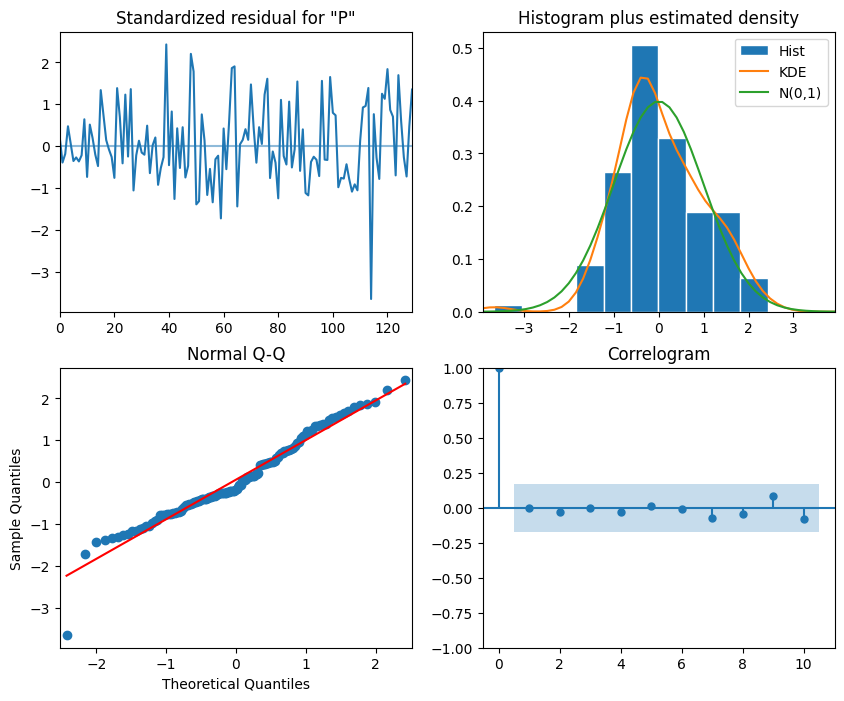

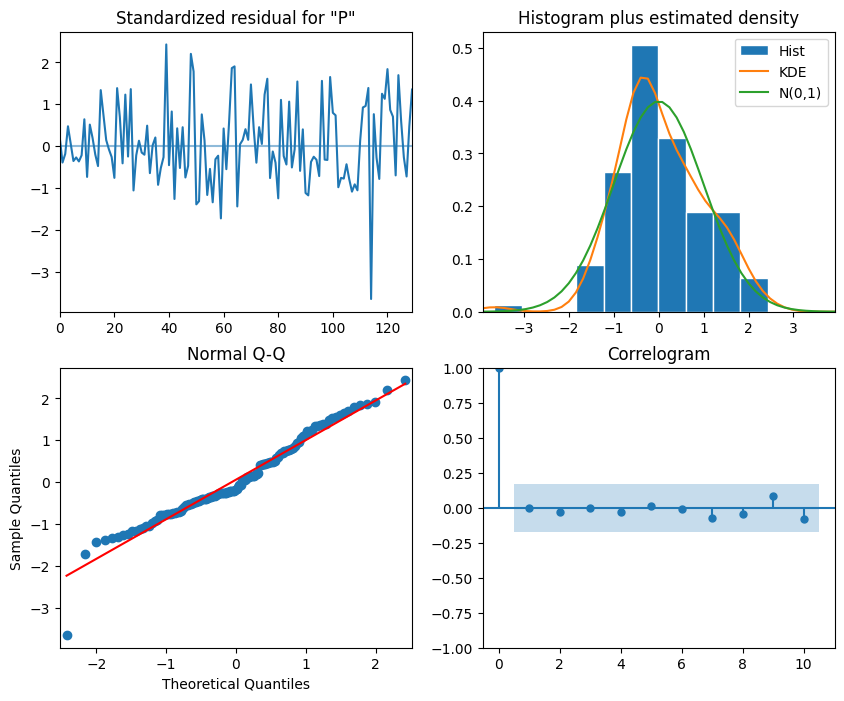

In [ ]:
ARIMA_model=SARIMAX(train,order=(11,2,3),simple_differencing=False)
ARIMA_model_fit=ARIMA_model.fit(disp=False)

ARIMA_model_fit.plot_diagnostics(figsize=(10,8))

左上→ホワイトノイズのように、残差にトレンドがなく、分散の推移がほぼ一定。

右上→残差の分布を表し、ピークが突出しているが、正規分布に近い。これはy=xにほぼ重なる直線が描かれている左下の図で裏付けられている。

右下→ラグ0の後に有意な自己相関係数は見当たらない。この分析からこの残差がホワイトノイズに似ていることがわかる。


これらの残差でリュング・ボックス検定をし、残差が独立していて無相関であることを確認します。

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals=ARIMA_model_fit.resid
result_df=acorr_ljungbox(residuals,np.arange(1,11,1))
result_df

,lb_stat,lb_pvalue
1,6.551733,0.010478
2,6.678223,0.035468
3,6.955162,0.073341
4,7.748964,0.101219
5,8.392800,0.135875
6,8.678755,0.192467
7,9.493079,0.219165
8,9.731334,0.284391
9,9.741643,0.371803
10,11.533096,0.317519


p値は最初の2つを除いて、0.05を超えています。ここでは有意性の境界を0.05に設定しているため、リュング・ボックス検定によると最初の2つは帰無仮説が棄却され、3つ目以降は帰無仮説が棄却せれず、ラグ3以降は残差が無相関であると結論付けられます。

残差のグラフィカルな分析では残差がホワイトノイズに似ているが、リュング・ボックス検定では、ラグ1とラグ2に何らかの相関があることが示されています。つまり、ARIMAモデルはこのデータから得られる情報を完全に補足できていません。この場合は、非季節モデルで季節データをモデル化しているため、このまま進むことにします。

ここでは、最後の12か月分のデータをテストデータセットとして使うことで1年間の月間航空旅客数を予測します。



In [ ]:
test=df[-12:]

test['naive_seasonal']=df['Passengers'].iloc[120:132].values

ARIMA(11,2,3)モデルによる予測値をtestに追加します。

In [ ]:
ARIMA_pred=ARIMA_model_fit.get_prediction(132,143).predicted_mean

test['ARIMA_pred']=ARIMA_pred

In [ ]:
ad_fuller_result = adfuller(df['Passengers'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641


ADF検定では、ADF統計量は0.82、p値0.99なので、帰無仮説を棄却できず、この時系列は定常ではありません。1次差分を適用した上で定常性をテストします。


In [ ]:
df_diff = np.diff(df['Passengers'], n=1)

ad_fuller_result = adfuller(df_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.8292668241700047
p-value: 0.05421329028382478


ADF統計量は-2.83、p値は0.054で、p値が0.05より大きいので帰無仮説を棄却できず、依然として非定常です。そこで、季節差分を適用した上で定常性をテストします。

In [ ]:
df_diff_seasonal_diff = np.diff(df_diff, n=12)

ad_fuller_result = adfuller(df_diff_seasonal_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -17.62486236026156
p-value: 3.823046855601547e-30


ADF統計量は-17.63、p値は3.82×10^(-30)です。ADF統計量は大きな負の値で、p値が0.05よりも小さいため、帰無仮説を棄却し、変換後の時系列が定常とみなせます。結果として差分を1回(d=1)、季節差分を1回(D=1)実行しました。

このステップが完了したらp,q,P,Qが取り得る値の範囲を定義し、一意なSARIMA(p,d,q)(P,D,Q)$_m$モデルをすべて適合させ、AICの値が最も小さいモデル選択することが出来ます。

In [ ]:
ps = range(0,4,1)
qs = range(0,4,1)
Ps = range(0,4,1)
Qs = range(0,4,1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['Passengers'][:-12]

d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.251468
1,"(2, 1, 1, 3)",894.094295
2,"(2, 1, 2, 1)",894.147180
3,"(1, 0, 1, 2)",894.287629
4,"(0, 1, 1, 2)",894.990210
...,...,...
250,"(0, 0, 2, 0)",906.940147
251,"(3, 2, 0, 3)",907.181875
252,"(0, 0, 3, 2)",907.451095
253,"(0, 0, 3, 0)",908.742583


AICの値が最も小さいのはSARIMA(2,1,1)(1,1,2)$_m$モデルとなります。このモデルを訓練データセットに適合させ、残差分析を実行しましょう。

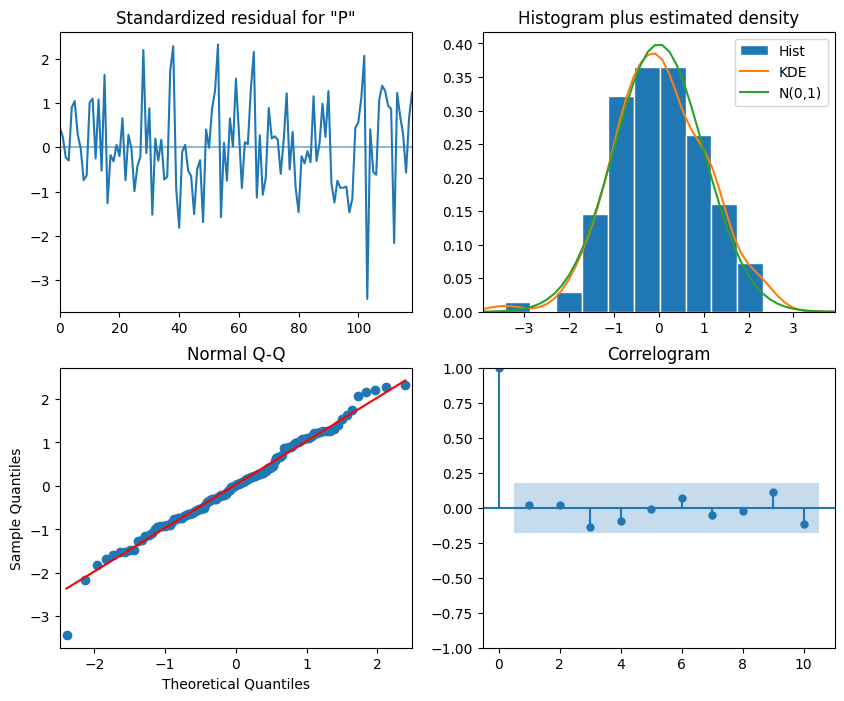

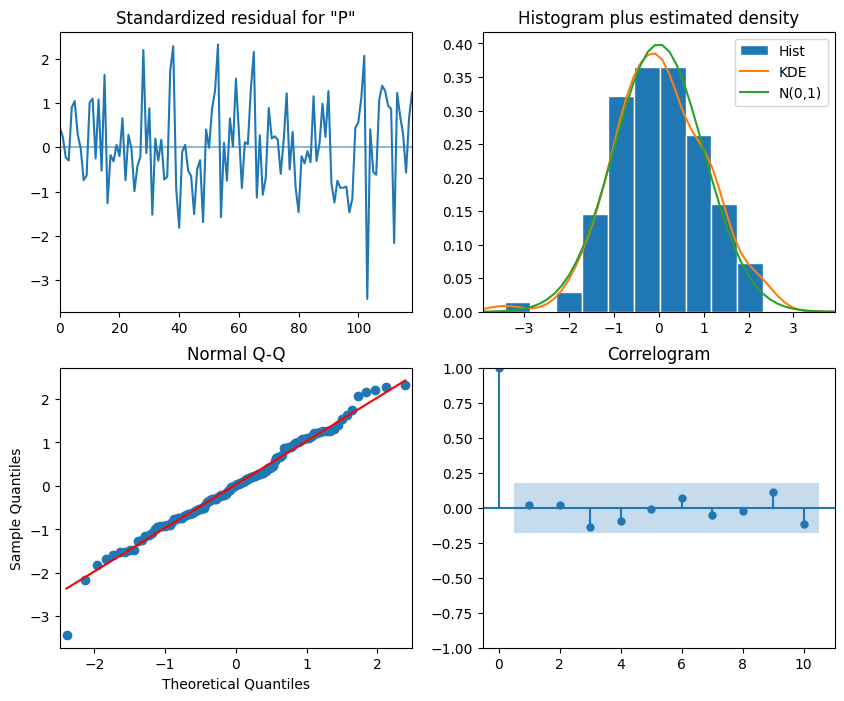

In [ ]:
SARIMA_model=SARIMAX(train,order=(2,1,1),seasonal_order=(1,1,2,12),
                     simple_difference=False)
SARIMA_model_fit=SARIMA_model.fit(disp=False)

SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

このモデルを予測に利用できるか判断する最後のテストは、リュング・ボックス検定です。

In [ ]:
residuals=SARIMA_model_fit.resid
result_df=acorr_ljungbox(residuals,np.arange(1,11,1))
result_df

,lb_stat,lb_pvalue
1,0.004900,0.944192
2,0.742117,0.690004
3,1.017222,0.797085
4,1.221722,0.874509
5,1.431753,0.920809
6,1.710553,0.944304
7,2.306753,0.940933
8,2.715821,0.950907
9,2.732092,0.973977
10,4.968883,0.893247


p値はすべて0.05を超えているので、帰無仮説が棄却されません。結論として、残差はホワイトノイズと同じように独立していて無相関です。

このモデルは残差分析によるすべてのテストにパスしており、いつでも予測に利用できる状態です。もう一度1960年の毎月の航空旅客数を予測し、予測値をテストデータセットの実測値と比較しましょう。

In [ ]:
SARIMA_pred=SARIMA_model_fit.get_prediction(132,143).predicted_mean

test['SARIMA_pred']=SARIMA_pred

結果が出そろったところで、2つのモデルの性能を比較し、最適な予測手法を決定できます。

### 8.3.3 各予測手法の性能を比較する

各手法の性能を比較する準備ができました。ここでは、単純な季節予測、ARIMAモデル、SARIMAモデルを比較します。モデルの評価には平均絶対誤差率(MAPE)を使います。

まず、テストデータセットの実測値に対して予測値を可視化しましょう。

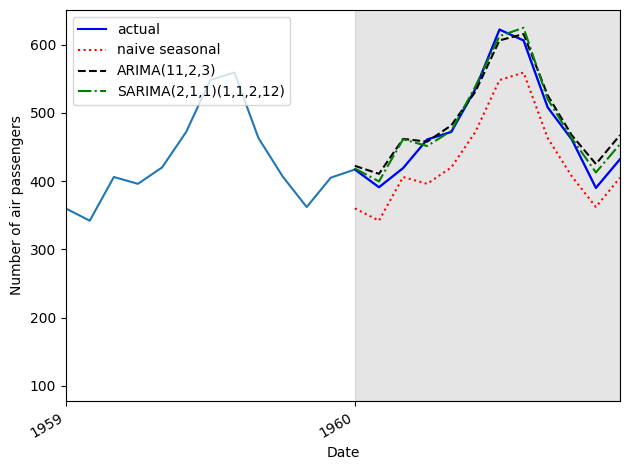

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['Month'],df['Passengers'])
ax.plot(test['Passengers'],'b-',label='actual')
ax.plot(test['naive_seasonal'],'r:',label='naive seasonal')
ax.plot(test['ARIMA_pred'],'k--',label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'],'g-.',label='SARIMA(2,1,1)(1,1,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan(132,143,color='#808080',alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0,145,12), np.arange(1949,1962,1))
ax.set_xlim(120,143)

fig.autofmt_xdate()
plt.tight_layout()

ARIMAモデルとSARIMAモデルが実測値にほぼ重なっているため、予測値が実測値に近いことがわかります。

各モデルのMAPEを計測して棒グラフにします。

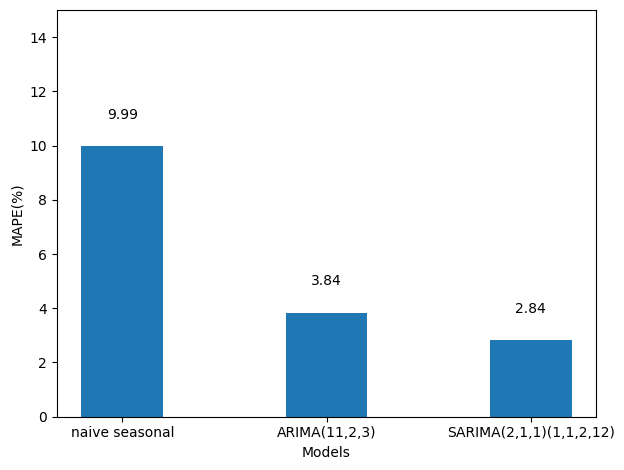

In [ ]:
def mape(y_true,y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

mape_naive_seasonal=mape(test['Passengers'],test['naive_seasonal'])
mape_ARIMA=mape(test['Passengers'],test['ARIMA_pred'])
mape_SARIMA=mape(test['Passengers'],test['SARIMA_pred'])

fig,ax=plt.subplots()

x=['naive seasonal','ARIMA(11,2,3)','SARIMA(2,1,1)(1,1,2,12)']
y=[mape_naive_seasonal,mape_ARIMA,mape_SARIMA]

ax.bar(x,y,width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE(%)')
ax.set_ylim(0,15)

for index, value in enumerate(y):
    plt.text(x=index,y=value+1,s=str(round(value,2)),ha='center')

plt.tight_layout()

MAPEが0に近いほど予測性能がいいため、最も性能が良い手法はSARIMAモデルとなります。